### Info
Este código filtra los tweets originales (raw) para dejar solo los que se van a ocupar.
Se junta los tweets unificados con los puntos ideales
Se crean los archivos necesarios para DANE

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Datasets_Tweets/tesis_data_raw.csv')
df2 = pd.read_csv('Datasets_Tweets/tesis_data_raw_second.csv')
del df['Unnamed: 0']
del df2['Unnamed: 0']

C:\Users\Zephyrus\AppData\Local\Temp\ipykernel_36760\2810537981.py:1: DtypeWarning: Columns (0,1,4,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Datasets_Tweets/tesis_data_raw.csv')
C:\Users\Zephyrus\AppData\Local\Temp\ipykernel_36760\2810537981.py:2: DtypeWarning: Columns (0,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('Datasets_Tweets/tesis_data_raw_second.csv')


In [3]:
df = pd.concat([df, df2], axis=0)
len(df)

15982806

## Preprocesamiento de datos

In [4]:
df = df[df['created_at'].notna()]
df = df[df.text.notna()]
print(df.created_at.min(), df.created_at.max())

2018-10-10 20:19:24+00:00 2022-07-14 00:00:00+00:00


In [5]:
df['time'] = pd.to_datetime(df['created_at'])

Eliminar tweets duplicados y los que no tienen fecha

In [6]:
df = df.drop_duplicates(subset=['id'])
df = df[df['time'].notna()]

In [8]:
len(df)

14403362

Filtrar tweets por fechas. Se dejan fuera los que están antes del 03/08 porque hubo problemas en la recolección de tweets

In [10]:
df_date_filter = df[(df.time > '2021-08-15') & (df.time < '2022-02-01')]
df_date_filter2 = df[df.time > '2022-03-08']
df_date = pd.concat([df_date_filter, df_date_filter2], axis=0)
len(df_date)

11729813

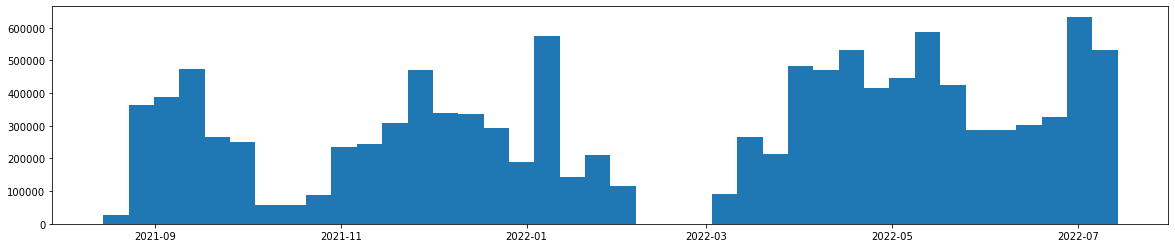

CPU times: total: 2min 35s
Wall time: 2min 42s


In [11]:
%%time
plt.figure(figsize=(20, 4))
plt.hist(df_date['time'], bins = 40)
plt.show()

In [12]:
df_date.to_csv('Datasets_Tweets/tesis_data_clean.csv', index=False)

### Juntar con TBIP

In [13]:
data = pd.read_csv('Datasets_Tweets/tesis_data_clean.csv')
tbip_data = pd.read_csv('Datasets_Tweets/ideal_point_tweets_tesis.csv')

C:\Users\Zephyrus\AppData\Local\Temp\ipykernel_36760\1239815842.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Datasets_Tweets/tesis_data_clean.csv')


In [14]:
data_with_tbip = data.merge(tbip_data, left_on='user_id', right_on='author', how='left')
del data_with_tbip['sd']
del data_with_tbip['author']
data_with_tbip.to_csv('Datasets_Tweets/tweets_cc.csv', index=False)

In [15]:
print("Cantidad tweets antes del merge con tbip:", len(data))
print("Cantidad tweets después del merge con tbip:", len(data_with_tbip))

Cantidad tweets antes del merge con tbip: 11729813
Cantidad tweets después del merge con tbip: 11729813


In [16]:
print("Cantidad usuarios únicos en data:", len(list(data.user_id.unique())))
print("Cantidad usuarios únicos en TBIP:", len(tbip_data))

Cantidad usuarios únicos en data: 468898
Cantidad usuarios únicos en TBIP: 192872


In [17]:
tw_ideal_point = len(data_with_tbip[~data_with_tbip.ideal_point.isnull()])
total = len(data_with_tbip)
print("Hay {} tweets asociados a un punto ideal de un total de {}: {perc:.2f}%".format(tw_ideal_point, total, perc=tw_ideal_point/total*100 ))

Hay 9501024 tweets asociados a un punto ideal de un total de 11729813: 81.00%


## Separar noticias

In [19]:
data = pd.read_csv('Datasets_Tweets/tweets_cc.csv')

C:\Users\Zephyrus\AppData\Local\Temp\ipykernel_36760\938299218.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Datasets_Tweets/tweets_cc.csv')


In [20]:
%%time
# Esto crea un dataframe basado en los retweet de la forma "usuario1 retweetea a usuario2"
df_rt = data[data['text'].str.contains("RT @")]
rt_dict = {}
ls_pares = []
for _, row in df_rt.iterrows():
    txt = row['text'].split(':')[0]
    rt_user = txt.split('@')[-1]
    try:
        pair = sorted([row.screen_name, rt_user])
        if pair[0] != pair[1]:
            pair[0] = str(pair[0])
            pair[1] = str(pair[1])
            key = ' '.join(pair)
            ls_pares.append(pair[0] + " " + pair[1])
            if key not in rt_dict:
                rt_dict[key] = 0
            rt_dict[key] += 1
    except:
        pass
df_pares = pd.DataFrame(ls_pares, columns=['users'])

users_cant = df_pares.groupby('users').size().reset_index(name='counts')
df_cant_pares = users_cant[users_cant['counts'] > 0]
ls_users = []

df_usuarios = df_cant_pares['users'].str.split(' ', expand=True).rename({0: 'user1', 1: 'user2'}, axis=1)
df_usuarios.head()

CPU times: total: 7min 38s
Wall time: 8min 6s


,user1,user2,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,0000000000000JL,EmiliaNoyupi,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,0000000000000JL,Fontirroig11S,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,0000000000000JL,Jpinostro,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,0000000000000JL,ale_sepulveda_,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,00001009082AA,Hugo_Gutierrez_,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [21]:
df_usuarios = df_usuarios[['user1', 'user2']]

In [22]:
u1 = df_usuarios.user1.to_list()
u2 = df_usuarios.user2.to_list()
u = list(set(u1 + u2))
print("Cantidad de usuarios distintos dentro los pares de retweets:",len(u))

Cantidad de usuarios distintos dentro los pares de retweets: 365796


In [23]:
df_user_filter = data[data.screen_name.isin(u)]

In [25]:
df_user_filter.to_csv('Datasets_Tweets/tweets_users.csv', index=False)

## Separar noticias

In [26]:
df = pd.read_csv('Datasets_Tweets/tweets_users.csv')

C:\Users\Zephyrus\AppData\Local\Temp\ipykernel_36760\1617656365.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Datasets_Tweets/tweets_users.csv')


In [27]:
def hashtags(dataset):
    hash_dic = {}
    for _, row in dataset.iterrows():
        text = row.text
        words = text.split(' ')
        ls_hashtags = []
        for w in words:
            try:
                if w[0] == '#':
                    ls_hashtags.append(w)
            except:
                pass
        for h in ls_hashtags:
            if h not in hash_dic:
                hash_dic[h] = 0
            hash_dic[h] += 1
    return hash_dic

def order_dic(dic_hashtags):
    for k in sorted(dic_hashtags, key=dic_hashtags.get, reverse=True):
        print(k, dic_hashtags[k])

### Maria Elisa Quinteros Presidencia (5 de Enero 2022)

In [28]:
meq = df[(df.created_at > '2022-01-05') & (df.created_at < '2022-01-12')]

In [29]:
meq = meq[meq.text.str.contains("Maria Elisa Quinteros|María Elisa Quinteros|MEQ")]

In [30]:
len(meq)

39462

In [31]:
meq.to_csv('Noticias/MEQ_tweets.csv', index=False)

### Borrador (Junio 2022)

In [32]:
borrado = df[(df.created_at > '2022-06-27') & (df.created_at < '2022-07-10')]

In [33]:
borrado = borrado[borrado.text.str.contains("borrador|Borrador")]

In [34]:
len(borrado)

9504

In [35]:
borrado.to_csv('Noticias/Borrador_tweets.csv', index=False)

### Fin del Senado (Mayo 2022)

In [36]:
senado = df[(df.created_at > '2022-04-12') & (df.created_at < '2022-04-20')]

In [37]:
senado = senado[senado.text.str.contains("Senado|senado")]

In [38]:
len(senado)

14592

In [39]:
senado.to_csv('Noticias/Senado_tweets.csv', index=False)

### Embarazo (Marzo 2022)

In [40]:
embarazo = df[(df.created_at > '2022-03-14') & (df.created_at < '2022-03-23')]

In [41]:
embarazo = embarazo[embarazo.text.str.contains("Aborto|aborto|interrupción voluntaria|interrupcion voluntaria|embarazo")]

In [42]:
len(embarazo)

8045

In [43]:
embarazo.to_csv('Noticias/Embarazo_tweets.csv', index=False)

## Crear archivos para DANE

### General

In [49]:
tbip_data = pd.read_csv('Datasets_Tweets/ideal_point_tweets_tesis.csv')
tweets_users = pd.read_csv('Datasets_Tweets/tweets_users.csv')

C:\Users\Zephyrus\AppData\Local\Temp\ipykernel_36760\249726428.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  tweets_users = pd.read_csv('Datasets_Tweets/tweets_users.csv')


In [47]:
tbip_dane = tbip_data.sort_values(by='author').drop(columns=['sd'], axis=1).rename({'author':'user_id'}, axis=1)
tbip_dane.to_csv('DANE_datasets/tbip_dane_all.csv', index=False)

In [60]:
users_with_tbip = list(tweets_users.user_id.unique())

In [64]:
tbip_dane_filter = tbip_dane[tbip_dane.user_id.isin(users_with_tbip)]
tbip_dane_filter.to_csv('DANE_datasets/tbip_dane_filter.csv', index=False)

In [63]:
len(tbip_dane), len(tbip_dane_filter)

(192872, 164398)

La cantidad de usuarios distintos en los tweets es 365k, mientras que la cantidad de usuarios en tbip_user_filter es 164k. Es decir que no todos los usuarios dentro de los pares de retweets tienen un punto ideal asociado, se va a tener que filtrar.

### Para las 4 noticias

Estos archivos ya están filtrados por los usuarios que están considerados dentro de los pares de retweets.

In [76]:
meq = pd.read_csv('Noticias/MEQ/MEQ_tweets.csv')
borrador = pd.read_csv('Noticias/Borrador/Borrador_tweets.csv')
embarazo = pd.read_csv('Noticias/Embarazo/Embarazo_tweets.csv')
senado = pd.read_csv('Noticias/Senado/Senado_tweets.csv')
tweets_users = pd.read_csv('Datasets_Tweets/tweets_users.csv')

C:\Users\Zephyrus\AppData\Local\Temp\ipykernel_36760\1909068181.py:5: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  tweets_users = pd.read_csv('Datasets_Tweets/tweets_users.csv')


In [77]:
usuarios_de_pares = list(tweets_users.user_id.unique())

In [79]:
len(senado), len(senado[senado.user_id.isin(usuarios_de_pares)])

(14592, 14592)

In [67]:
len(meq), len(meq[~meq.ideal_point.isnull()])

(39462, 33932)

#### Archivos TBIP

In [80]:
tbip_meq = meq[['user_id', 'ideal_point']][~meq.ideal_point.isnull()].drop_duplicates().sort_values(by='user_id').reset_index().drop(columns=['index'])
tbip_borrador = borrador[['user_id', 'ideal_point']][~borrador.ideal_point.isnull()].drop_duplicates().sort_values(by='user_id').reset_index().drop(columns=['index'])
tbip_emb = embarazo[['user_id', 'ideal_point']][~embarazo.ideal_point.isnull()].drop_duplicates().sort_values(by='user_id').reset_index().drop(columns=['index'])
tbip_senado = senado[['user_id', 'ideal_point']][~senado.ideal_point.isnull()].drop_duplicates().sort_values(by='user_id').reset_index().drop(columns=['index'])

In [81]:
tbip_user_meq = tbip_meq.user_id.to_list()
tbip_user_sen = tbip_senado.user_id.to_list()
tbip_user_borr = tbip_borrador.user_id.to_list()
tbip_user_emb = tbip_emb.user_id.to_list()

In [82]:
def user2natural(tbip_df):
    cont = 0
    user_map = {}
    for _, row in tbip_df.iterrows():
        cont += 1
        user_map[row.user_id] = cont
    return user_map

In [83]:
dic_user = user2natural(tbip_dane_filter)

dic_user es un diccionario que tiene el id original del usuario y hace un mapeo hacia números naturales.

In [84]:
def map_users(tbip_df):
    tbip_df['user_id'] = tbip_df.user_id.apply(lambda x: dic_user[x])

In [85]:
map_users(tbip_meq)
map_users(tbip_borrador)
map_users(tbip_emb)
map_users(tbip_senado)

#### Archivos pares retweet

In [93]:
def pares(data):
    # Esto crea un dataframe basado en los retweet de la forma "usuario1 retweetea a usuario2"
    df_rt = data[data['text'].str.contains("RT @")]
    rt_dict = {}
    ls_pares = []
    for _, row in df_rt.iterrows():
        txt = row['text'].split(':')[0]
        rt_user = txt.split('@')[-1]
        try:
            pair = sorted([row.screen_name, rt_user])
            if pair[0] != pair[1]:
                pair[0] = str(pair[0])
                pair[1] = str(pair[1])
                key = ' '.join(pair)
                ls_pares.append(pair[0] + " " + pair[1])
                if key not in rt_dict:
                    rt_dict[key] = 0
                rt_dict[key] += 1
        except:
            pass
    df_pares = pd.DataFrame(ls_pares, columns=['users'])

    users_cant = df_pares.groupby('users').size().reset_index(name='counts')
    df_cant_pares = users_cant[users_cant['counts'] > 0]
    ls_users = []

    df_usuarios = df_cant_pares['users'].str.split(' ', expand=True).rename({0: 'user1', 1: 'user2'}, axis=1)
    return df_usuarios[['user1', 'user2']]

In [94]:
def screen2id(name):
    if name not in dic_screen:
        return 'None'
    user_id = dic_screen[name]
    return user_id

In [95]:
df_subset = df.drop_duplicates(subset=['screen_name'])

In [96]:
%%time
dic_screen = {}
c = 0
for _, row in df_subset.iterrows():
    if (c % 200000 == 0):
        print(c)
    user_id = row.user_id
    screen = row.screen_name
    if user_id not in dic_screen:
        dic_screen[screen] = user_id
    c += 1

0
200000
CPU times: total: 19.7 s
Wall time: 46.9 s


In [98]:
def get_user_ids(df_pares):
    df_pares['user1_id'] = df_pares.user1.apply(screen2id)
    df_pares['user2_id'] = df_pares.user2.apply(screen2id)
    return df_pares

In [99]:
pares_meq = pares(meq)
pares_borr = pares(borrador)
pares_emb = pares(embarazo)
pares_sen = pares(senado)

In [101]:
pares_meq = get_user_ids(pares_meq)
pares_borr = get_user_ids(pares_borr)
pares_emb = get_user_ids(pares_emb)
pares_sen = get_user_ids(pares_sen)

In [103]:
pares_meq = pares_meq[['user1_id', 'user2_id']]
pares_borr = pares_borr[['user1_id', 'user2_id']]
pares_emb = pares_emb[['user1_id', 'user2_id']]
pares_sen = pares_sen[['user1_id', 'user2_id']]

In [106]:
pares_meq = pares_meq[pares_meq.user1_id != 'None']
pares_meq = pares_meq[pares_meq.user2_id != 'None']
pares_sen = pares_sen[pares_sen.user1_id != 'None']
pares_sen = pares_sen[pares_sen.user2_id != 'None']
pares_borr = pares_borr[pares_borr.user1_id != 'None']
pares_borr = pares_borr[pares_borr.user2_id != 'None']
pares_emb = pares_emb[pares_emb.user1_id != 'None']
pares_emb = pares_emb[pares_emb.user2_id != 'None']

In [140]:
# tbip_user_meq = [int(x) for x in tbip_user_meq]
# tbip_user_emb = [int(x) for x in tbip_user_emb]
# tbip_user_sen = [int(x) for x in tbip_user_sen]
# tbip_user_borr = [int(x) for x in tbip_user_borr]

In [112]:
pares_meq = pares_meq[(pares_meq.user1_id.isin(tbip_user_meq)) & (pares_meq.user2_id.isin(tbip_user_meq))]
pares_sen = pares_sen[(pares_sen.user1_id.isin(tbip_user_sen)) & (pares_sen.user2_id.isin(tbip_user_sen))]
pares_borr = pares_borr[(pares_borr.user1_id.isin(tbip_user_borr)) & (pares_borr.user2_id.isin(tbip_user_borr))]
pares_emb = pares_emb[(pares_emb.user1_id.isin(tbip_user_emb)) & (pares_emb.user2_id.isin(tbip_user_emb))]

In [113]:
def user_pairs2norm(pares_df):
    pares_df['user1_id'] = pares_df.user1_id.apply(lambda user: dic_user[user])
    pares_df['user2_id'] = pares_df.user2_id.apply(lambda user: dic_user[user])

In [115]:
user_pairs2norm(pares_meq)
user_pairs2norm(pares_sen)
user_pairs2norm(pares_emb)
user_pairs2norm(pares_borr)

C:\Users\Zephyrus\AppData\Local\Temp\ipykernel_36760\2486555115.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pares_df['user1_id'] = pares_df.user1_id.apply(lambda user: dic_user[user])
C:\Users\Zephyrus\AppData\Local\Temp\ipykernel_36760\2486555115.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pares_df['user2_id'] = pares_df.user2_id.apply(lambda user: dic_user[user])


In [129]:
final_users_meq = list(set(pares_meq.user1_id.to_list() + pares_meq.user2_id.to_list()))
final_users_sen = list(set(pares_sen.user1_id.to_list() + pares_sen.user2_id.to_list()))
final_users_emb = list(set(pares_emb.user1_id.to_list() + pares_emb.user2_id.to_list()))
final_users_borr = list(set(pares_borr.user1_id.to_list() + pares_borr.user2_id.to_list()))

In [135]:
tbip_meq_filter = tbip_meq[tbip_meq.user_id.isin(final_users_meq)]
tbip_sen_filter = tbip_senado[tbip_senado.user_id.isin(final_users_sen)]
tbip_emb_filter = tbip_emb[tbip_emb.user_id.isin(final_users_emb)]
tbip_borr_filter = tbip_borrador[tbip_borrador.user_id.isin(final_users_borr)]

In [137]:
len(tbip_meq), len(tbip_meq_filter)

(12208, 9111)

In [142]:
len(tbip_senado), len(tbip_sen_filter)

(7200, 4816)

In [144]:
len(tbip_emb), len(tbip_emb_filter)

(4406, 3145)

In [157]:
len(final_users_meq), len(tbip_meq_filter.user_id.to_list())

(9111, 9111)

### Crear archivos csv

TBIP (Features)

In [158]:
tbip_meq_filter.to_csv('Noticias/MEQ/MEQ_tbip.csv', index=False)
tbip_borr_filter.to_csv('Noticias/Borrador/Borrador_tbip.csv', index=False)
tbip_emb_filter.to_csv('Noticias/Embarazo/Embarazo_tbip.csv', index=False)
tbip_sen_filter.to_csv('Noticias/Senado/Senado_tbip.csv', index=False)

In [159]:
tbip_meq_filter.to_csv('Noticias/MEQ/MEQ_tbip.txt', header=None, index=None, sep=' ', mode='w')
tbip_borr_filter.to_csv('Noticias/Borrador/Borrador_tbip.txt', header=None, index=None, sep=' ', mode='w')
tbip_emb_filter.to_csv('Noticias/Embarazo/Embarazo_tbip.txt', header=None, index=None, sep=' ', mode='w')
tbip_sen_filter.to_csv('Noticias/Senado/Senado_tbip.txt', header=None, index=None, sep=' ', mode='w')

Pares (Edges)

In [161]:
pares_meq.to_csv('Noticias/MEQ/MEQ_pares.csv', index=False)
pares_borr.to_csv('Noticias/Borrador/Borrador_pares.csv', index=False)
pares_emb.to_csv('Noticias/Embarazo/Embarazo_pares.csv', index=False)
pares_sen.to_csv('Noticias/Senado/Senado_pares.csv', index=False)

In [162]:
pares_meq.to_csv('Noticias/MEQ/MEQ_pares.txt', header=None, index=None, sep=' ', mode='w')
pares_borr.to_csv('Noticias/Borrador/Borrador_pares.txt', header=None, index=None, sep=' ', mode='w')
pares_emb.to_csv('Noticias/Embarazo/Embarazo_pares.txt', header=None, index=None, sep=' ', mode='w')
pares_sen.to_csv('Noticias/Senado/Senado_pares.txt', header=None, index=None, sep=' ', mode='w')

### Revisar archvios

In [163]:
pmeq = pd.read_csv('Noticias/MEQ/MEQ_pares.csv')
pborr = pd.read_csv('Noticias/Borrador/Borrador_pares.csv')
pemb = pd.read_csv('Noticias/Embarazo/Embarazo_pares.csv')
psen = pd.read_csv('Noticias/Senado/Senado_pares.csv')

# Estándar para DANE

In [75]:
pmeq = pd.read_csv('Noticias/MEQ/MEQ_pares.csv')
pborr = pd.read_csv('Noticias/Borrador/Borrador_pares.csv')
pemb = pd.read_csv('Noticias/Embarazo/Embarazo_pares.csv')
psen = pd.read_csv('Noticias/Senado/Senado_pares.csv')

In [76]:
tmeq = pd.read_csv('Noticias/MEQ/MEQ_tbip.csv')
tborr = pd.read_csv('Noticias/Borrador/Borrador_tbip.csv')
temb = pd.read_csv('Noticias/Embarazo/Embarazo_tbip.csv')
tsen = pd.read_csv('Noticias/Senado/Senado_tbip.csv')

In [77]:
def user2natural(tbip_df):
    cont = -1
    user_map = {}
    for _, row in tbip_df.iterrows():
        cont += 1
        user_map[row.user_id] = cont
    return user_map

In [78]:
def map_users(tbip_df, dic):
    tbip_df['user_id'] = tbip_df.user_id.apply(lambda x: dic[x])

In [79]:
def user_pairs2norm(pares_df, dic):
    pares_df['user1_id'] = pares_df.user1_id.apply(lambda user: dic[user])
    pares_df['user2_id'] = pares_df.user2_id.apply(lambda user: dic[user])

In [80]:
def swap_values(df):
    for idx, row in df.iterrows():
        if row.user2_id < row.user1_id:
            temp = row.user2_id
            df.loc[idx, 'user2_id'] = row.user1_id
            df.loc[idx, 'user1_id'] = temp

In [81]:
dic_meq = user2natural(tmeq)
dic_sen = user2natural(tsen)
dic_borr = user2natural(tborr)
dic_emb = user2natural(temb)

In [82]:
map_users(tmeq, dic_meq)
map_users(tsen, dic_sen)
map_users(tborr, dic_borr)
map_users(temb, dic_emb)

In [83]:
user_pairs2norm(pmeq, dic_meq)
user_pairs2norm(psen, dic_sen)
user_pairs2norm(pborr, dic_borr)
user_pairs2norm(pemb, dic_emb)

In [84]:
swap_values(pmeq)
swap_values(psen)
swap_values(pborr)
swap_values(pemb)

In [85]:
pmeq.sort_values(by=['user1_id','user2_id'], inplace=True)
psen.sort_values(by=['user1_id','user2_id'], inplace=True)
pborr.sort_values(by=['user1_id','user2_id'], inplace=True)
pemb.sort_values(by=['user1_id','user2_id'], inplace=True)

Guardar archivos en DANE_datasets

In [86]:
tmeq.to_csv('DANE_datasets/MEQ/MEQ_tbip.csv', index=False)
tborr.to_csv('DANE_datasets/Borrador/Borrador_tbip.csv', index=False)
temb.to_csv('DANE_datasets/Embarazo/Embarazo_tbip.csv', index=False)
tsen.to_csv('DANE_datasets/Senado/Senado_tbip.csv', index=False)

In [87]:
tmeq.to_csv('DANE_datasets/MEQ/MEQ_tbip.txt', header=None, index=None, sep=' ', mode='w')
tborr.to_csv('DANE_datasets/Borrador/Borrador_tbip.txt', header=None, index=None, sep=' ', mode='w')
temb.to_csv('DANE_datasets/Embarazo/Embarazo_tbip.txt', header=None, index=None, sep=' ', mode='w')
tsen.to_csv('DANE_datasets/Senado/Senado_tbip.txt', header=None, index=None, sep=' ', mode='w')

In [88]:
pmeq.to_csv('DANE_datasets/MEQ/MEQ_pares.csv', index=False)
pborr.to_csv('DANE_datasets/Borrador/Borrador_pares.csv', index=False)
pemb.to_csv('DANE_datasets/Embarazo/Embarazo_pares.csv', index=False)
psen.to_csv('DANE_datasets/Senado/Senado_pares.csv', index=False)

In [89]:
pmeq.to_csv('DANE_datasets/MEQ/MEQ_pares.txt', header=None, index=None, sep=' ', mode='w')
pborr.to_csv('DANE_datasets/Borrador/Borrador_pares.txt', header=None, index=None, sep=' ', mode='w')
pemb.to_csv('DANE_datasets/Embarazo/Embarazo_pares.txt', header=None, index=None, sep=' ', mode='w')
psen.to_csv('DANE_datasets/Senado/Senado_pares.txt', header=None, index=None, sep=' ', mode='w')

In [91]:
pd.read_csv('DANE_datasets/MEQ/MEQ_tbip.csv')

,user_id,ideal_point
0,0,-0.317720
1,1,-0.678006
2,2,-0.796868
3,3,-0.621242
4,4,0.139729
...,...,...
9106,9106,-0.634176
9107,9107,-0.536071
9108,9108,-0.122388
9109,9109,-0.750262
